In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
import random

df = pd.read_csv('data.csv',encoding = "ISO-8859-1")

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37309 entries, 0 to 37308
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    37309 non-null  object 
 1   StockCode    37309 non-null  object 
 2   Description  37192 non-null  object 
 3   Quantity     37309 non-null  int64  
 4   InvoiceDate  37309 non-null  object 
 5   UnitPrice    37308 non-null  float64
 6   CustomerID   24429 non-null  float64
 7   Country      37308 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 2.3+ MB


In [ ]:
# description, customer ID have missing values

df.shape

(541909, 8)

In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [ ]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,37309.000000,37308.000000,24429.000000
mean,8.011901,6.230193,15540.025339
std,61.414804,148.693371,1731.742013
min,-9360.000000,0.000000,12347.000000
25%,1.000000,1.280000,14210.000000
50%,2.000000,2.510000,15570.000000
75%,7.000000,4.250000,17158.000000
max,2880.000000,13541.330000,18269.000000


<h4>
The dataset corresponds to the sales of a UK-based and registered non-store online retail in a specific timeline.
    
The mean unit price of the commodities sold by this Retail is 4.61 pounds. The maximum unit price of a particular product is 38970, which is probably a luxury product.

The Retail sold a total of 541,909 items from 01/12/2010 and 09/12/2011. It sells around 10 items in each transaction on average, and it makes sense because the main customers are wholesalers.

The maximum number of items sold in one transaction is 80995.

The number of Customers registered in the database is 406829. A large number of customers aren't registered.

</h4>

In [ ]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,117
Quantity,0
InvoiceDate,0
UnitPrice,1
CustomerID,12880
Country,1


<h4>There are Null Values present in the "Description" and "CustomerID" columns.</h4>

In [ ]:
df_new = df.copy()

In [ ]:

null_stock_codes = df_new[df_new['Description'].isnull()].StockCode.values

for code in null_stock_codes:
    if df_new[df_new.StockCode == code].shape[0]> 1:

        probable_desc = df_new[df_new.StockCode == code]['Description'].value_counts().index[0]

        df_new.loc[(df_new.StockCode == code) & (df_new['Description'].isnull()), 'Description'] = probable_desc


In [ ]:
df_new.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,117
Quantity,0
InvoiceDate,0
UnitPrice,1
CustomerID,12880
Country,1


In [ ]:
df_new.fillna(value = {'Description': 'Description not found', 'CustomerID': 0}, inplace = True)

In [ ]:
df_new.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,1
CustomerID,0
Country,1


<h4>

A copy of the Dataframe is created and the null values are handled.

For the Description column ->

Firstly, the Stock Code for each Null Description is recorded and checked to see if the product exists for other transactions. If it exists, then the most common Description for that Stock Code is imputed in place of the Null Description. If it doesn't exist, the Description is replaced with the string 'Description not found'.

For the CustomerID column ->

The Null values are replaced with 0. Research was done to find some similarity, in the using InvoiceDate column. However, I was not able to find a connection.

</h4>

In [ ]:
df_new.duplicated().sum()

473

<h4>There's 5268 Duplicate values in the dataset. </h4>

In [ ]:
df_new.shape

(37309, 8)

In [ ]:
df_new = df_new.drop_duplicates()

In [ ]:
df_new.shape

(36836, 8)

<h4>The duplicated values are handled by deleting them.</h4>

<b> Invoice Column </b>

In [ ]:
df_new.InvoiceNo.nunique()

1774

From 01/12/2010 to 09/12/2011, they have made <b> 25900 </b> new transactions, which may or may not have involved the same customers.

<b> Stock Code Column </b>

In [ ]:
df_new.StockCode.nunique()

2754

In [ ]:
df_new.StockCode.value_counts()

,count
StockCode,
85123A,211
22423,162
22086,160
22834,143
22111,135
...,...
85018C,1
21316,1
90141B,1


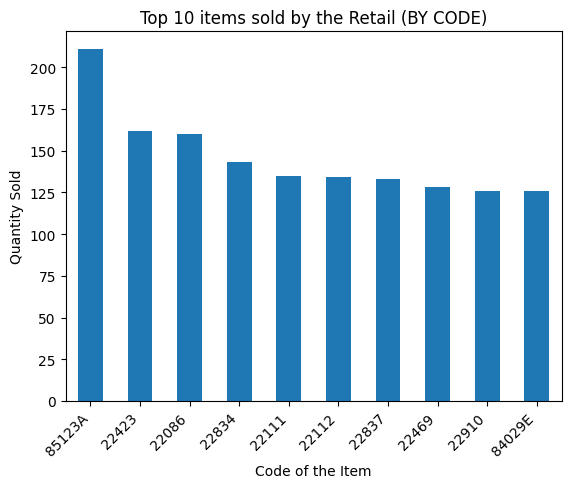

In [ ]:
fig, ax = plt.subplots()

sold_item_counts = df_new.StockCode.value_counts()[:10]

sold_item_counts.plot(kind = 'bar', title = 'Top 10 items sold by the Retail (BY CODE)', xlabel = 'Code of the Item', ylabel = 'Quantity Sold')

plt.xticks(rotation = 45, ha = 'right')

plt.show()

The Retail has <b> 4070 </b> Different and Unique items in their stock.

The most sold item is the Item with the <b>Code 85123A</b>.

<b> Quantity of Items Column </b>

In [ ]:
df.Quantity.value_counts()

,count
Quantity,
1,12659
2,5897
12,3212
3,2645
6,2618
...,...
-19,1
-43,1
-35,1


In [ ]:
df.Quantity.max()

2880

In [ ]:
df.Quantity.mean()

8.01190061379292

In [ ]:
df[df.Quantity ==80995]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


On average, the Retail sells around <b> 10 items </b> to each customer.

However, the most common number of Items sold in one Transaction is <b> 1 </b>, which happened <b> 148227 times </b>.

The maximum number of items sold in one transaction by the Retail is <b> 80995 </b> . The item was <b> PAPER CRAFT, LITTLE BIRDIE <b> , which has a unit price of 2.08.


<b> Description Column </b>

In [ ]:
df_new.Description.nunique()

2699

In [ ]:
df_new.Description.value_counts()

,count
Description,
WHITE HANGING HEART T-LIGHT HOLDER,215
REGENCY CAKESTAND 3 TIER,161
PAPER CHAIN KIT 50'S CHRISTMAS,160
HAND WARMER BABUSHKA DESIGN,143
SCOTTIE DOG HOT WATER BOTTLE,135
...,...
BEADED CRYSTAL HEART GREEN LARGE,1
SMALL CHUNKY GLASS ROMAN BOWL,1
TEATIME PUSH DOWN RUBBER,1


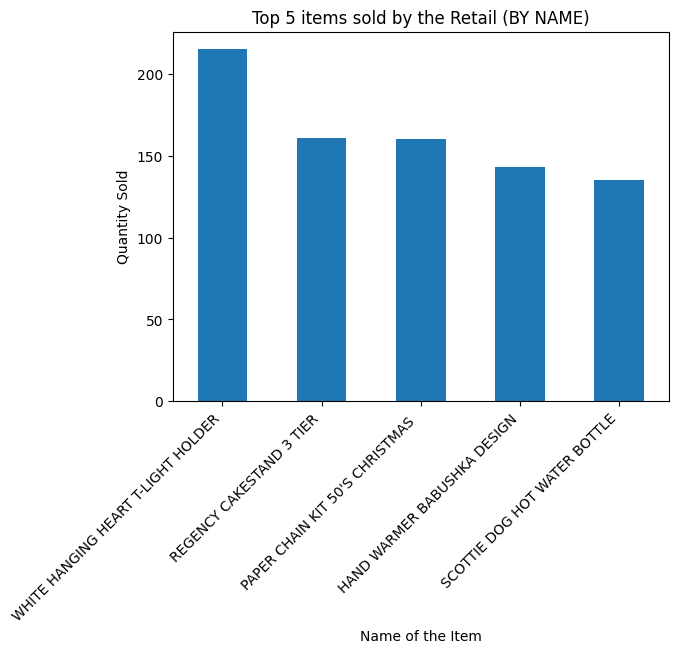

In [ ]:
fig, ax = plt.subplots()

sold_item_counts = df_new.Description.value_counts()[:5]

sold_item_counts.plot(kind = 'bar', title = 'Top 5 items sold by the Retail (BY NAME)', xlabel = 'Name of the Item', ylabel = 'Quantity Sold')

plt.xticks(rotation = 45,fontsize = 10,  ha = 'right')

plt.show()

We can come to the conclusion that the <b> "WHITE HANGING HEART T-LIGHT HOLDER" </b> is the most sold item for this retail.

However, there is a mismatch in the Unique Numbers for Stock Code and Description columns.

This means that each stock code can have multiple entries in the "Description" column.

It also suggests that the "WHITE HANGING HEART T-LIGHT HOLDER" can be present under different Stock Codes.



<b>DATE and TIME COLUMN </b>

In [ ]:
date_format = '%m/%d/%Y %H:%M'
df_new['invoice_date'] = df_new['InvoiceDate'].apply(lambda x: datetime.strptime(x, date_format))

df_new.drop(['InvoiceDate'], axis = 1, inplace = True)

ValueError: time data '12/17/20' does not match format '%m/%d/%Y %H:%M'

In [ ]:
df_new.sample(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
6790,536980,22910,PAPER CHAIN KIT VINTAGE CHRISTMAS,1,12/3/2010 14:26,2.95,17819.0,United Kingdom
845,536464,85231G,ORANGE SCENTED SET/9 T-LIGHTS,5,12/1/2010 12:23,0.85,17968.0,United Kingdom
28249,538633,84993B,75 BLACK PETIT FOUR CASES,1,12/13/2010 13:28,0.42,16726.0,United Kingdom


In [ ]:
df_new.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,float64
Country,object


In [ ]:
df_new.invoice_date.value_counts().index[0]

AttributeError: 'DataFrame' object has no attribute 'invoice_date'

The most transactions that took place in this retail happened exactly at <b> 2.41 pm on the 31st of October, 2011.</b>

<b> Unit Price column </b>

In [ ]:
df_new.UnitPrice.describe()

,UnitPrice
count,36835.000000
mean,6.277650
std,149.644288
min,0.000000
25%,1.280000
50%,2.510000
75%,4.250000
max,13541.330000


In [ ]:
df_new.UnitPrice.value_counts()

,count
UnitPrice,
1.25,3011
0.85,2765
2.95,2316
1.65,1925
2.10,1763
...,...
281.00,1
52.00,1
12.95,1


In [ ]:
df_new[df_new.UnitPrice == df_new.UnitPrice.max()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
15016,C537630,AMAZONFEE,AMAZON FEE,-1,12/7/2010 15:04,13541.33,0.0,United Kingdom
15017,537632,AMAZONFEE,AMAZON FEE,1,12/7/2010 15:08,13541.33,0.0,United Kingdom
16356,C537651,AMAZONFEE,AMAZON FEE,-1,12/7/2010 15:49,13541.33,0.0,United Kingdom


The <b> Average Unit Price </b> of the products of this Retail is <b> 4.63 pounds </b>

The highest Unit Price of a product sold by the Retail is <b> 38970 </b>.

However, after further research it looks like it isn't an actual product. Further research is required.


<b> COUNTRY column </b>

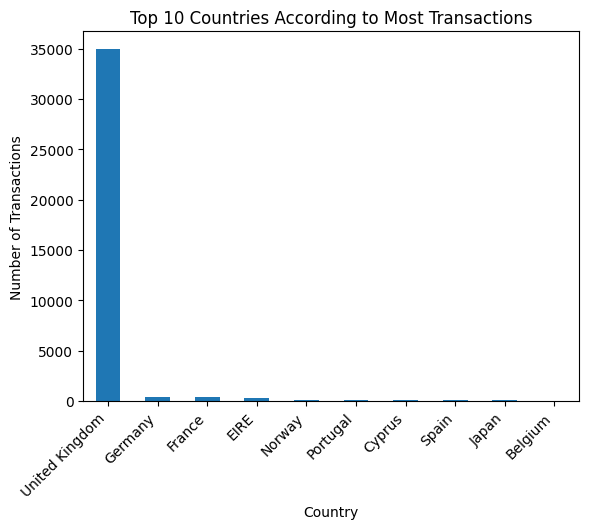

In [ ]:
fig, ax = plt.subplots()

sold_item_counts = df_new.Country.value_counts()[:10]

sold_item_counts.plot(kind = 'bar', title = 'Top 10 Countries According to Most Transactions', xlabel = 'Country', ylabel = 'Number of Transactions')
plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:
df.Country.nunique()

23

<b> United Kingdom </b> is where most of the transaction takes place for this retail. That is understandable, because the Retail is based on the United Kingdom itself.

Apart from the UK, the countries with which the retail has blooming business with are <b> Germany and France. </b>

Furthermore, the Retail had conducted business with <b> 38 </b> different countries during the given timeframe.

<b> CustomerID column </b>

In [ ]:
df_new.CustomerID = df_new.CustomerID.astype(int)

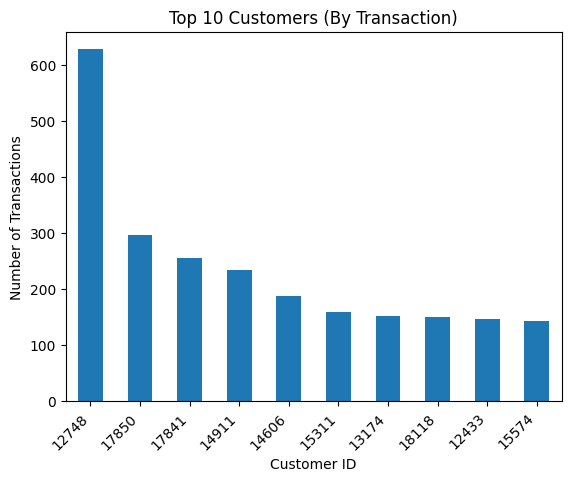

In [ ]:

fig, ax = plt.subplots()

customer_counts = df_new.CustomerID.value_counts()[1:11]

customer_counts.plot(kind = 'bar', title = 'Top 10 Customers (By Transaction)', xlabel = 'Customer ID', ylabel = 'Number of Transactions')
plt.xticks(rotation=45, ha='right')

plt.show()

The Retail store did the most business with <b>Customer ID 17841</b>. The Customer made almost <b> 8000 transactions</b> in the given timeframe.

This detail is only for Customers who are registered.

<h3>CANCELED INVOICES</h3>

In [ ]:
canceled_invoice_index = []

canceled_invoices = []

for index, entry in enumerate(df_new.InvoiceNo):

    if 'C' in entry[0]:

        canceled_invoice_index.append(index)
        canceled_invoices.append(entry)



In [ ]:
len(canceled_invoices)

9251

In [ ]:
canceled_invoice_df = df_new.iloc[canceled_invoice_index]

In [ ]:
canceled_invoice_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
34512,C539402,21527,RED RETROSPOT TRADITIONAL TEAPOT,-1,12/17/2010 12:19,6.95,17315,United Kingdom
34591,C539409,POST,POSTAGE,-1,12/17/2010 12:58,18.00,12720,Germany
36165,C539438,22655,VINTAGE RED KITCHEN CABINET,-1,12/17/2010 15:11,295.00,16607,United Kingdom
36300,C539448,20802,SMALL GLASS SUNDAE DISH CLEAR,-36,12/17/2010 16:25,0.42,15157,United Kingdom


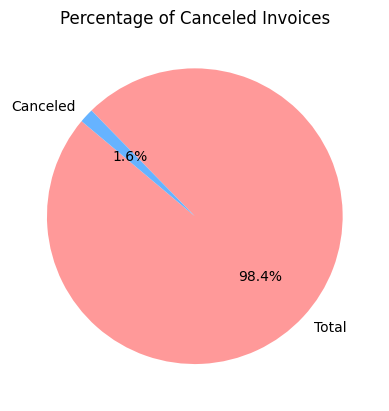

In [ ]:
fig, ax = plt.subplots()

transaction_quantity = [df_new.shape[0],canceled_invoice_df.shape[0]]

labels = ['Total', 'Canceled']

colors = ['#ff9999','#66b3ff']

plt.pie(transaction_quantity, labels = labels,autopct='%1.1f%%', colors = colors,startangle=140)

plt.title('Percentage of Canceled Invoices')

plt.show()

In [ ]:
canceled_invoice_df.CustomerID.value_counts()[1:2]

,count
CustomerID,
15514,31


The Customer with the most Canceled Invoices is <b> CustomerID 14911 </b>, with a total of <b> 226 cancels </b>

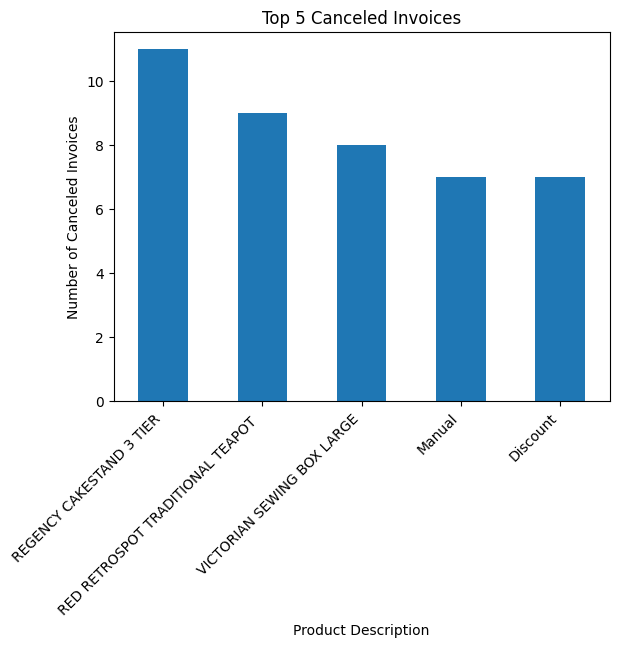

In [ ]:
canceled_invoice_df.Description.value_counts()

fig, ax = plt.subplots()

canceled_product_counts = canceled_invoice_df.Description.value_counts()[:5]

canceled_product_counts.plot(kind = 'bar', title = 'Top 5 Canceled Invoices', xlabel = 'Product Description', ylabel = 'Number of Canceled Invoices')
plt.xticks(rotation=45, ha='right')

plt.show()

The Products With the most Canceled Invoices are <b> Manual </b> and <b>REGENCY CAKESTAND 3 TIER </b>

In [ ]:
df_new.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [ ]:
df_new.shape

(36836, 8)

In [ ]:
index_labels_to_drop = df_new.index[canceled_invoice_index]

In [ ]:
df_s = df_new.drop(index_labels_to_drop)

In [ ]:
df_s.shape

(36249, 8)

In [ ]:
df_s.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
6064,536876,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,2,12/3/2010 11:36,5.06,0,United Kingdom
5884,536876,22539,MINI JIGSAW DOLLY GIRL,1,12/3/2010 11:36,0.85,0,United Kingdom
9120,537192,22094,RED RETROSPOT TISSUE BOX,2,12/5/2010 13:42,1.25,16402,United Kingdom
24653,538349,22634,CHILDS BREAKFAST SET SPACEBOY,1,12/10/2010 14:59,10.00,0,United Kingdom
1868,536544,20724,RED RETROSPOT CHARLOTTE BAG,3,12/1/2010 14:32,1.66,0,United Kingdom


<h5><b>Removing elements that have values less than 0 in the 'Quantity' column, 'Unit Price' column</h3>

In [ ]:
less_than_zero_quantity = df_s[df_s.Quantity < 0].index

less_than_zero_unit_price = df_s[df_s.UnitPrice < 0].index

df_s.drop(less_than_zero_quantity, inplace = True)
df_s.drop(less_than_zero_unit_price, inplace = True)

In [ ]:
df_s.shape

(526052, 8)

<h5><b>Removing elements with letters in the 'InvoiceNo' column, which indicates unsuccessful transactions</h3>

In [ ]:
invoice_with_letters_index = []

for index, entry in enumerate(df_s.InvoiceNo):

    try:

        temp = int(entry)

    except ValueError:
        invoice_with_letters_index.append(index)


In [ ]:
df_s.drop(invoice_with_letters_index, inplace = True)

In [ ]:
df_s.to_csv('cleaned_ecommerce_data.csv', index=False)

In [ ]:
#df_s.to_csv('Cleaned_E_Comm_Dataset.csv')

<h2> <b> Popularity-Based Recommendation System </b></h2>

In [ ]:
most_sold_items = df_s.groupby(['Description', 'StockCode'])['Quantity'].sum().reset_index().sort_values(by = 'Quantity', ascending = False)

In [ ]:
top_10_most_sold = most_sold_items[:10]
top_10_most_sold

,Description,StockCode,Quantity
2743,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84077,4996
2682,WHITE HANGING HEART T-LIGHT HOLDER,85123A,3513
1205,HAND WARMER BABUSHKA DESIGN,22834,3065
1706,PACK OF 72 RETROSPOT CAKE CASES,21212,2743
1190,GROW A FLYTRAP OR SUNFLOWER IN TIN,22693,2593
1544,MINI PAINT SET VINTAGE,22492,2529
2420,SMALL POPCORN HOLDER,22197,2466
1729,PAPER CHAIN KIT 50'S CHRISTMAS,22086,2329
172,ASSORTED COLOUR BIRD ORNAMENT,84879,2315
673,CREAM HEART CARD HOLDER,22189,2253


<h3> The above recommendation system is based on the most Popular products of the E-commerce store. They can be recommended to all users, since they are the most sold products, which suggests that these products are Top Quality.</h3>

In [ ]:
data_from_past_year = df_s[df_s.invoice_date > datetime(2010,12,31)]



most_sold_items_recent = data_from_past_year.groupby(['Description','StockCode'])['Quantity'].sum().reset_index().sort_values(by = 'Quantity', ascending = False)

AttributeError: 'DataFrame' object has no attribute 'invoice_date'

In [ ]:
top_10_most_sold_from_past_year = most_sold_items_recent[:10]
top_10_most_sold_from_past_year

NameError: name 'most_sold_items_recent' is not defined

<h3> This recommendation system is based on the most Popular products of the E-commerce store from the past year. These products are currently Trending in the store. They can be recommended to all users, since they are the most sold products, which suggests that these products are Top Quality.  <br><br>

It can be concluded that all of "PAPER CRAFT", "MEDIUM CERAMIC TOP STORAGE JAR" have been sold in the year of 2011, and not in 2010. These are the most TRENDING products.

</h3>

<h2><b>Item-Based Collaborative Filtering<b></h2>

In [ ]:
df_s.CustomerID.nunique()

838

In [ ]:
df_with_customer_id = df_s[df_s['CustomerID'] > 0]

In [ ]:
df_with_customer_id.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [ ]:
user_item_matrix = df_with_customer_id.pivot_table(index = 'CustomerID', columns = 'Description', values = 'Quantity', aggfunc = 'sum', fill_value = 0)

random_index = random.randint(0,3876)
product_chosen_at_random = user_item_matrix.columns[random_index]


print(f'The product chosen at random for testing purposes is - {product_chosen_at_random}')

item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

similar_items_for_item_based_collaborative_filtering = item_similarity_df[product_chosen_at_random].sort_values(ascending=False)[1:11].index.tolist()

print(f"""

The top 10 Products based on Item-Based Collaborative Filtering, for the Product: {product_chosen_at_random} are:

{', '.join(similar_items_for_item_based_collaborative_filtering)}

""")

The product chosen at random for testing purposes is - CERAMIC PIRATE CHEST MONEY BANK


The top 10 Products based on Item-Based Collaborative Filtering, for the Product: CERAMIC PIRATE CHEST MONEY BANK are:

PIGGY BANK RETROSPOT , CERAMIC STRAWBERRY MONEY BOX, MIRRORED WALL ART STARS, MAGAZINE RACK GEBRA ASSORTED , A4 WALL TIDY BLUE OFFICE, CD WALL TIDY RED FLOWERS, DOORSTOP FOOTBALL DESIGN, MIRRORED WALL ART SKULLS, CHARLIE & LOLA WASTEPAPER BIN BLUE, MIDNIGHT GLAMOUR SCARF KNITTING KIT






<h3> This recommendation system recommends items by analyzing the TOTAL QUANTITY PURCHASED for items based on the Users' previous SPENDINGS. <br><br>

If a User Frequently purchases certain products together, this system will suggest those products as part of the Recommendation system.

</h3>

<h2><b>User-Based Collaborative Filtering<b></h2>

In [ ]:
item_user_matrix = df_with_customer_id.pivot_table(index = 'Description', columns = 'CustomerID', values = 'Quantity', aggfunc = 'sum', fill_value = 0)


In [ ]:
#user_item_matrix = df_with_customer_id.pivot_table(index = 'CustomerID', columns = 'Description', values = 'Quantity', aggfunc = 'sum', fill_value = 0)

from scipy.sparse import csr_matrix

user_item_matrix_csr = csr_matrix(item_user_matrix.values)

In [ ]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(user_item_matrix_csr)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
distances, indices = model_knn.kneighbors(item_user_matrix.iloc[random_index,:].values.reshape(1, -1), n_neighbors = 10)

In [ ]:
similar_items_for_user_based_collaborative_filtering = []

for i in range(1, len(distances.flatten())):
    similar_items_for_user_based_collaborative_filtering.append(item_user_matrix.index[indices.flatten()[i]])


In [ ]:
print(f"""

The top 10 Products based on Item-Based Collaborative Filtering, for the Product: {product_chosen_at_random} are:

{', '.join(similar_items_for_user_based_collaborative_filtering)}

""")



The top 10 Products based on Item-Based Collaborative Filtering, for the Product: CERAMIC PIRATE CHEST MONEY BANK are:

PIGGY BANK RETROSPOT , CERAMIC STRAWBERRY MONEY BOX, A4 WALL TIDY BLUE OFFICE, CD WALL TIDY RED FLOWERS, MIRRORED WALL ART STARS, MAGAZINE RACK GEBRA ASSORTED , DOORSTOP FOOTBALL DESIGN, MIRRORED WALL ART SKULLS, CHARLIE & LOLA WASTEPAPER BIN BLUE





<h3> This recommendation system ecommends items by finding users who have similar tastes or preferences. It suggests items that similar users have purchased, assuming that if two users have agreed on certain items, they are likely to purchase other Similar products.

</h3>

<h2><b>Content-Based Filtering<b></h2>

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer


# tfv = TfidfVectorizer(min_df=1,  max_features=None,
#             strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
#             ngram_range=(1, 3),
#             stop_words = 'english')

# tfidf_matrix = tfv.fit_transform(df_s['Description'])

In [ ]:
#description_similarity = cosine_similarity(tfidf_matrix)

In [ ]:
# from sklearn.decomposition import TruncatedSVD

# svd = TruncatedSVD(n_components=100, random_state=42)
# tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

# description_similarity_sparse = csr_matrix(tfidf_matrix_reduced)
# description_similarity = cosine_similarity(description_similarity_sparse)


In [ ]:
# description_similarity = cosine_similarity(description_similarity_sparse)

<h3>Due to Computational Limitations, it wasn't possible to develop this system.</h3>

<h2><b>Hybrid Recommendation System<b></h2>

<h4>Combining the Recommendation Systems developed to provide more Comprehensive Recommendation.</h4>

In [ ]:
#POPULARITY BASED SYSTEM

most_sold_items = df_s.groupby(['Description', 'StockCode'])['Quantity'].sum().reset_index().sort_values(by='Quantity', ascending=False)
top_10_most_sold = most_sold_items[:10]

# RECENT-POPULARITY BASED SYSTEM
data_from_past_year = df_s[df_s['invoice_date'] > datetime(2010, 12, 31)]
most_sold_items_recent = data_from_past_year.groupby(['Description', 'StockCode'])['Quantity'].sum().reset_index().sort_values(by='Quantity', ascending=False)



KeyError: 'invoice_date'

<h5>FOR CHOOSING A RANDOM PRODUCT TO TEST THE RECOMMENDATION SYSTEM, WE CHOOSE A RANDOM INDEX </h5>

In [ ]:
random_index = random.randint(0, user_item_matrix.shape[1]-1)


In [ ]:
#ITEM-BASED COLLOBORATIVE FILTERING

#TAKING ONLY CUSTOMERS WHO HAVE CUSTOMER ID
df_with_customer_id = df_s[df_s['CustomerID'] > 0]

user_item_matrix = df_with_customer_id.pivot_table(index='CustomerID', columns='Description', values='Quantity', aggfunc='sum', fill_value=0)

product_chosen_at_random = user_item_matrix.columns[random_index]

item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)
similar_items_item_based = item_similarity_df[product_chosen_at_random].sort_values(ascending=False)[1:11].index.tolist()


In [ ]:
product_chosen_at_random

'RETROSPOT RED WASHING UP GLOVES'

In [ ]:
#USER-BASED COLLOBORATIVE FILTERING

item_user_matrix = df_with_customer_id.pivot_table(index='Description', columns='CustomerID', values='Quantity', aggfunc='sum', fill_value=0)
user_item_matrix_csr = csr_matrix(item_user_matrix.values)
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_item_matrix_csr)

distances, indices = model_knn.kneighbors(item_user_matrix.iloc[random_index, :].values.reshape(1, -1), n_neighbors=10)
similar_items_user_based = [item_user_matrix.index[indices.flatten()[i]] for i in range(1, len(distances.flatten()))]


<h4> To develop the hybrid model, we'll set scores for the Prodcuts Recommended by Each System. <br><br>

From there, we'll normalize the scores, so that they can be comparable. <br><br>

After that, we will consider the scores for each product, add them together (or aggregate them) and the total score will be the Final Recommendation Score. <br><br>

We will be using the scores of the RECENT-POPULARITY BASED SYSTEM, USER-BASED COLLOBORATIVE FILTERING SYSTEM, and ITEM-BASED COLLOBORATIVE FILTERING system only.

</h4>

In [ ]:
# popularity_scores = {row['Description']: row['Quantity'] for _, row in most_sold_items.iterrows()}
recent_popularity_scores = {row['Description']: row['Quantity'] for _, row in most_sold_items_recent.iterrows()}
item_based_scores = {item: score for item, score in zip(similar_items_item_based, range(10, 0, -1))}
user_based_scores = {item: score for item, score in zip(similar_items_user_based, range(10, 0, -1))}


NameError: name 'most_sold_items_recent' is not defined

<h4> The scores are extracted above.</h4>

In [ ]:
def normalize_scores(scores):
    max_score = max(scores.values())
    min_score = min(scores.values())
    normalized = {key: (value - min_score) / (max_score - min_score) for key, value in scores.items()}
    return normalized


#popularity_scores_normalized = normalize_scores(popularity_scores)
recent_popularity_scores_normalized = normalize_scores(recent_popularity_scores)
item_based_scores_normalized = normalize_scores(item_based_scores)
user_based_scores_normalized = normalize_scores(user_based_scores)

NameError: name 'recent_popularity_scores' is not defined

<h4>The scores are normalized above.</h4>

In [ ]:
def aggregate_scores(*score_dicts):
    aggregate = {}
    for score_dict in score_dicts:
        for item, score in score_dict.items():
            if item not in aggregate:
                aggregate[item] = 0
            aggregate[item] += score
    return aggregate

final_scores = aggregate_scores(recent_popularity_scores_normalized, item_based_scores_normalized, user_based_scores_normalized)

<h4>The scores are Added Together above and stored as Dictionary in the "final_scores".</h4>

In [ ]:
top_hybrid_recommendations = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)[:10]


<h4><b>Top 10 Products To Be Recommended</b></h4>

In [ ]:
products = []
for product in top_hybrid_recommendations:
    products.append(product[0])


In [ ]:


print(f"""

The Product which is Considered is: {product_chosen_at_random}

""")




The Product which is Considered is: RETROSPOT RED WASHING UP GLOVES




In [ ]:
print(f"""

The final products to be recommended are:

{', '.join(products)}

""")



The final products to be recommended are:

DOORKNOB CRACKED GLAZE BLUE, DOORKNOB CRACKED GLAZE IVORY, PEG BAG APPLE DESIGN, MISELTOE HEART WREATH CREAM, FRYING PAN RED POLKADOT , PAPER CRAFT , LITTLE BIRDIE, MEDIUM CERAMIC TOP STORAGE JAR, LUNCH BAG RED SPOTTY, SET/5 RED SPOTTY LID GLASS BOWLS, WORLD WAR 2 GLIDERS ASSTD DESIGNS


